# Tutorial 2: Automatic Feature Extraction/Engineering

---

### Introduction

In this notebook, we will extract/engineer features using a deep learning method called autoencoder.
The input and the output of this method will be the galaxy images. An autoencoder is an artificial neural network with a symmetric structure which is trained to reconstruct its input onto the output layer. The output of the first half of the network represents an encoding of the input data. ([source](https://arxiv.org/abs/2206.06165)).

First, we import some libraries:

In [6]:
import matplotlib.pyplot as plt # for plotting data/graphs
import numpy as np # For handling N-DIMENSIONAL ARRAYS

import tensorflow as tf #An end-to-end machine learning platform, focusing on training deep learning models
from tensorflow.keras import layers, losses # Implementation of the Keras API, the high-level API of TensorFlow.
from tensorflow.keras.models import Model #This displays graphs 



---

### Reading in data

In [7]:
from galaxy_mnist import GalaxyMNISTHighrez

dataset_train = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=True  # by default, or False for canonical test set
)
# for the testing data
dataset_test = GalaxyMNISTHighrez(
    root='data_import/data',
    download=True,
    train=False  # by default, or False for canonical test set
)

In [8]:
# defining the training and testing labels and image samples
images_train = dataset_train.data
images_test = dataset_test.data
labels_train = dataset_train.targets
labels_test = dataset_test.targets
classes = GalaxyMNISTHighrez.classes

---

### Pre-processing 

In [9]:
from source.pre import pre_processing #  A predefined function to pre-process the data as we did in tutorial 1

In [10]:
# pre-processing(data, size) function takes two arguments
# 1. data: the data to be processed
# 2. The size for which the data needs to be reduced.
images_trainPre = pre_processing(images_train, 56)
images_testPre = pre_processing(images_test, 56)

In [11]:
images_trainPre.shape # the shape of the training data

(8000, 56, 56)

Displaying images after pre-processing

label: smooth_round


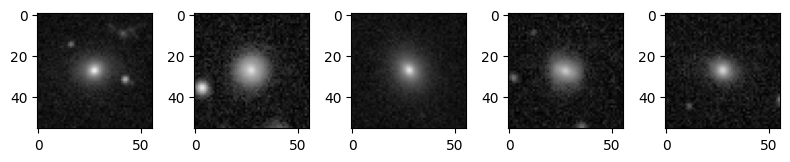

label: smooth_cigar


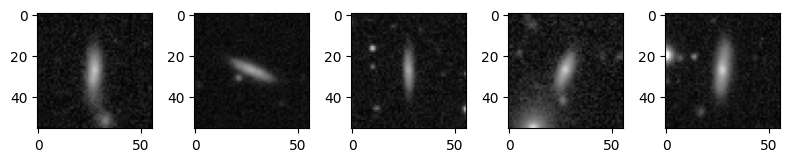

label: edge_on_disk


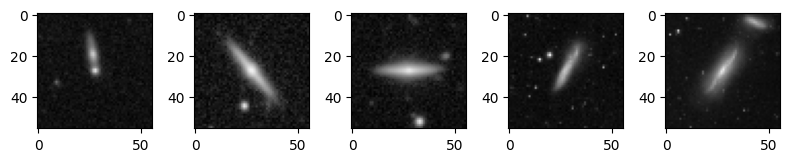

label: unbarred_spiral


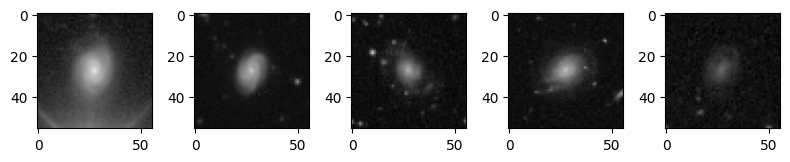

In [12]:
rows = 1
columns = 5
for j in range(len(GalaxyMNISTHighrez.classes)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        train_image = images_trainPre[(labels_train == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(train_image*255,cmap='gray', vmin=0, vmax=255) 
                            # we have to multiply the image by 255 to restore the original values
    print("label: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show() 

---

### Shallow Autoencoder

Now we will train the autoencoder nural network on the data that we pre-processed. The original code can be found [here](https://www.tensorflow.org/tutorials/generative/autoencoder).

In [20]:
latent_dim = 64 # the number of features to be encoded, this can change 
num, length, width  = images_trainPre.shape
# need to document how excatly it works

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(length*width, activation='sigmoid'),
      layers.Reshape((length, width))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

shallow_model = Autoencoder(latent_dim)

2022-11-14 20:03:58.385649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-14 20:03:58.385724: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-14 20:03:58.385758: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-008): /proc/driver/nvidia/version does not exist
2022-11-14 20:03:58.386236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
shallow_model.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=2)

`EarlyStopping()` has a few options and by default:
 - `monitor='val_loss'`: to use validation loss as performance measure to terminate the training.
- `patience=0`: is the number of epochs with no improvement. The value 0 means the training is terminated as soon as the performance measure gets worse from one epoch to the next.

In [23]:
shallow_model.fit(np.array(images_trainPre), np.array(images_trainPre),
                epochs=50,
                shuffle=True,
                validation_data=(np.array(images_trainPre), np.array(images_trainPre)), callbacks=[early_stopping])

Epoch 1/50
250/250 [==============================] - 3s 8ms/step - loss: 0.0136 - val_loss: 0.0057
Epoch 2/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 3/50
250/250 [==============================] - 2s 6ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 4/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 5/50
250/250 [==============================] - 2s 7ms/step - loss: 0.0041 - val_loss: 0.0051


You can notice that runing this code is quite fast, this is becuase the model is too shallow.

In [24]:
shallow_model.save("./shallowModel_save") # saving the model (shallow)


INFO:tensorflow:Assets written to: /users/hussein/work/galaxy-cluster/shallowModel_save/assets


In [25]:
encoded_imgs = shallow_model.encoder(images_testPre).numpy()
decoded_imgs = shallow_model.decoder(encoded_imgs).numpy()

In [26]:
print(decoded_imgs.shape)

(2000, 56, 56)


Original: smooth_round


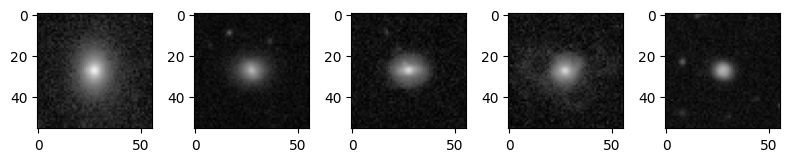

Reconstructed: smooth_round


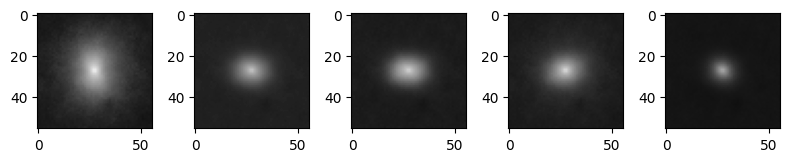

Original: smooth_cigar


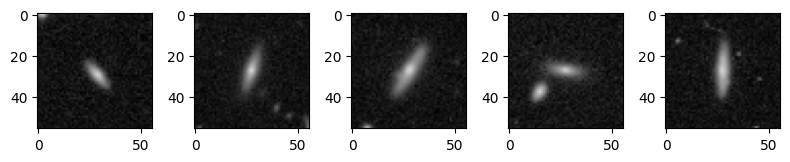

Reconstructed: smooth_cigar


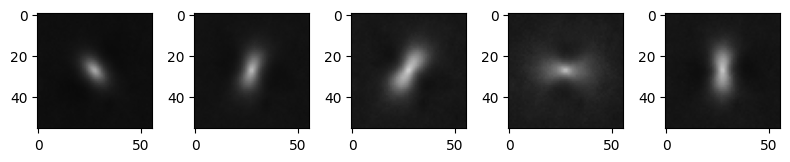

Original: edge_on_disk


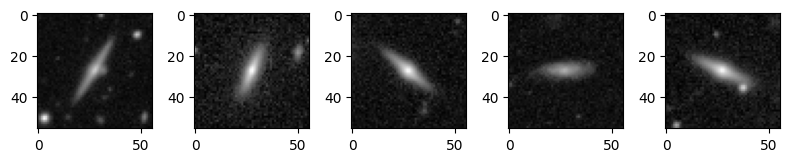

Reconstructed: edge_on_disk


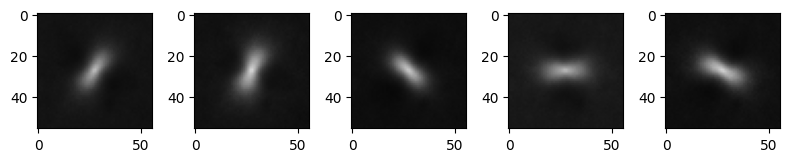

Original: unbarred_spiral


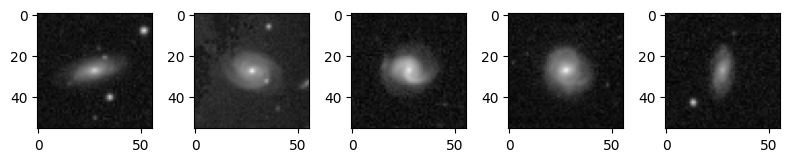

Reconstructed: unbarred_spiral


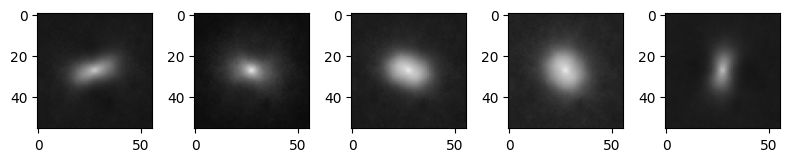

In [31]:
rows = 1
columns = 5
for j in range(len(GalaxyMNISTHighrez.classes)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = images_testPre[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='gray', vmin=0, vmax=255) 
                            # we have to multiply the image by 255 to restore the original values
    print("Original: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show() 
    
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = decoded_imgs[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='gray', vmin=0, vmax=255) 
                            # we have to multiply the image by 255 to restore the original values
    print("Reconstructed: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show() 
    
    

**Exercise 1:** Which classes do you think will be confused with the others?

In [32]:
### -- Answer here --


---

### Deep convolutional autoencoder

A convolutional autoencoder makes use of convolutional neural network mechanisms to reduce and engineer the images. Now let us try a more complicated model and notice the difference, time and image quality

In [33]:
class GalaxyEncoder(Model):
    def __init__(self):
        super(GalaxyEncoder, self).__init__()
        self.encoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(56,56,1)),
            layers.Conv2D(16, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Conv2D(8, (3,3), 1, padding="same", activation="relu"),
            layers.MaxPool2D((2,2), padding="same", strides=2),
            layers.Flatten()
        ])
        self.decoder = tf.keras.Sequential ([
            layers.InputLayer(input_shape=(1568)),
            layers.Reshape((14, 14, 8)),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(8, (3,3), 1, padding="same", activation="relu"),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(16, (3,3), 1, padding="same", activation="relu"),
            layers.Conv2D(1, (3,3), 1, padding="same", activation="sigmoid")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [34]:
deep_model = GalaxyEncoder()

In [35]:
deep_model.compile(optimizer='sgd', loss='mse')


In [36]:
deep_model.build((None, 56,56,1))
deep_model.summary()

Model: "galaxy_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 1568)              1320      
                                                                 
 sequential_3 (Sequential)   (None, 56, 56, 1)         1897      
                                                                 
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [37]:
early_stopping = EarlyStopping(patience=1)

In [48]:
deep_model.fit(np.array(images_trainPre), np.array(images_trainPre),
                epochs=40,
                shuffle=True,
                validation_data=(np.array(images_trainPre), np.array(images_trainPre)), callbacks=[early_stopping])
# start with the 2nd tut instead of waiting

Epoch 1/40
250/250 [==============================] - 54s 217ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 2/40
250/250 [==============================] - 53s 213ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 3/40
250/250 [==============================] - 53s 213ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 4/40
250/250 [==============================] - 55s 219ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 5/40
250/250 [==============================] - 52s 210ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 6/40
250/250 [==============================] - 54s 216ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/40
250/250 [==============================] - 53s 211ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 8/40
250/250 [==============================] - 52s 209ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 9/40
250/250 [==============================] - 52s 210ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/40
250/250 [==============================] - 52s 210ms/step - l

**Exercise 2:** Save the deep model for later use

In [49]:
### -- Code here --


In [50]:
encoded_imgs = deep_model.encoder(images_testPre).numpy()
decoded_imgs = deep_model.decoder(encoded_imgs).numpy()

Original: smooth_round


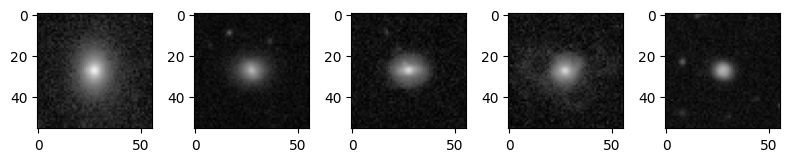

Reconstructed: smooth_round


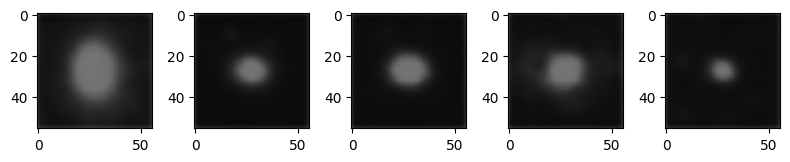

Original: smooth_cigar


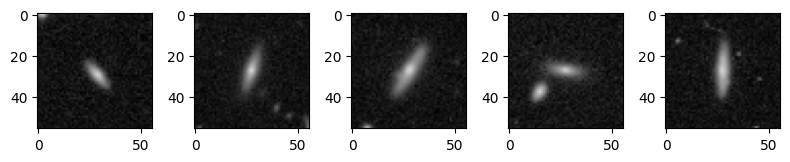

Reconstructed: smooth_cigar


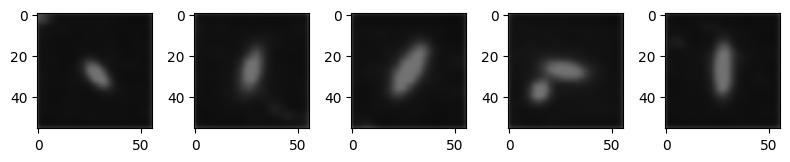

Original: edge_on_disk


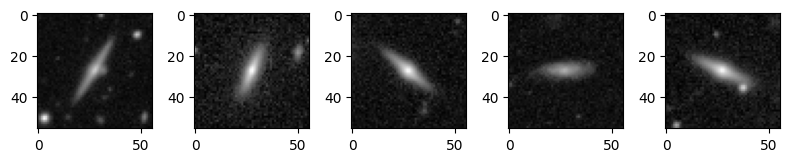

Reconstructed: edge_on_disk


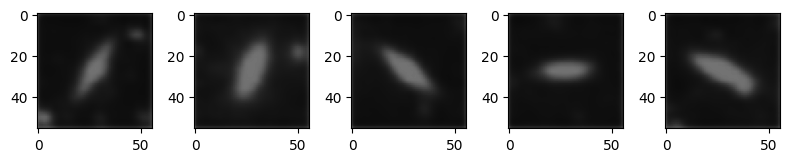

Original: unbarred_spiral


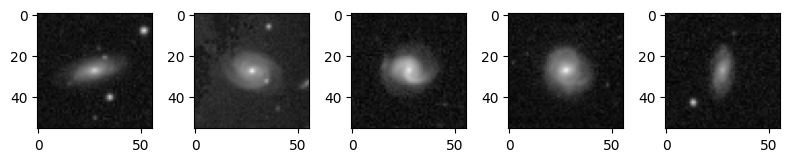

Reconstructed: unbarred_spiral


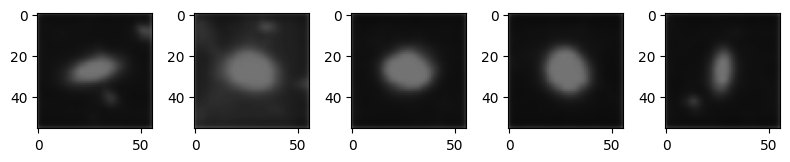

In [51]:
rows = 1
columns = 5
for j in range(len(GalaxyMNISTHighrez.classes)):
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = images_testPre[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='gray', vmin=0, vmax=255) 
                            # we have to multiply the image by 255 to restore the original values
    print("Original: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show() 
    
    fig = plt.figure(figsize=(8, 8))# Figure is 8 inches by 8 inches
    for i in range (columns):    # Create images in each column
        test_image = decoded_imgs[(labels_test == j)][i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(test_image*255,cmap='gray', vmin=0, vmax=255) 
                            # we have to multiply the image by 255 to restore the original values
    print("Reconstructed: "+str(GalaxyMNISTHighrez.classes[j]))
    plt.tight_layout()
    plt.show() 

**Exercise 3:** Visually how do the reconstructed images from the deep model compare to the shallow one?

In [52]:
### -- Answer here --


I think including the time in thier analysis will be very good.

---

### Extracting the engineered features from the autoencoder model

Now, we need to extract the feature space from the shallow encoder model

In [17]:
import tensorflow as tf
import pandas as pd

In [18]:
model = tf.keras.models.load_model('shallowModel_save/') # recalling the model
print(model.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                200768    
                                                                 
 sequential_1 (Sequential)   (None, 56, 56)            203840    
                                                                 
Total params: 404,608
Trainable params: 404,608
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
auto_features_train = model.encoder.predict(images_trainPre) # extracting the features for the training data
auto_features_test = model.encoder.predict(images_testPre)   # extracting the features for the testing data

63/63 [==============================] - 0s 1ms/step


In [20]:
auto_df_train = pd.DataFrame(auto_features_train) #turning the data into a dataframe
auto_df_test = pd.DataFrame(auto_features_test) #turning the data into a dataframe

In [21]:
print(auto_df_train.shape) 

(8000, 64)


In [22]:
auto_df_train.head(3)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1.556710,3.153725,1.985421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.557651,1.821148,4.396018,0.0,3.638083,0.0,5.858932,2.546805,2.380832
1,1.198205,0.924895,2.075049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.498417,0.000000,3.670418,0.0,3.085184,0.0,3.564224,2.238075,1.801486
2,1.776421,10.345140,3.423920,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.193197,6.739635,8.568306,0.0,6.095815,0.0,15.860380,3.763647,2.302731


---

#### **_Saving data for later use_**

We can save the data so that we can call it up again in subsequent notebooks

In [23]:
%store auto_df_train
%store auto_df_test
%store labels_train
%store labels_test
%store classes

Stored 'auto_df_train' (DataFrame)
Stored 'auto_df_test' (DataFrame)
Stored 'labels_train' (Tensor)
Stored 'labels_test' (Tensor)
Stored 'classes' (list)
